In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [2]:
# Read data into pandas
japan = pd.read_excel(".././data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel(".././data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel(".././data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel(".././data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel(".././data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel(".././data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel(".././data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel(".././data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
start = '2022-11-30'
end = '2024-02-29'

returns = returns[start:end]
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2022-11-30,0.015203,0.008111,0.006473,0.027591,0.022254,0.033766,0.031007,0.012353
2022-12-01,0.004696,0.011698,0.031925,0.006215,0.008994,-0.010355,-0.000415,0.018750
2022-12-02,-0.005062,0.001881,0.012595,-0.004660,0.000764,-0.000357,-0.001075,-0.003214
2022-12-05,-0.025375,-0.009717,-0.013008,-0.014311,-0.011392,-0.031756,-0.018008,-0.017878
2022-12-06,-0.001802,0.005859,0.013072,0.002010,-0.004604,0.011790,-0.014302,0.003283
...,...,...,...,...,...,...,...,...
2024-02-23,0.000896,0.004941,0.013749,0.000761,0.002265,-0.011384,0.000569,0.005744
2024-02-26,0.000017,-0.001527,-0.002584,-0.003889,-0.001238,0.001952,-0.003762,-0.002077
2024-02-27,-0.000156,-0.001967,-0.006976,0.004972,0.001623,0.017314,0.001770,-0.001041


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5494230434382372
            Iterations: 10
            Function evaluations: 92
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5717092906404564
            Iterations: 7
            Function evaluations: 65
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4957696098314157
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6585265185768785
            Iterations: 10
            Function evaluations: 92
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6668221293899037
            Iterations: 10
            Function ev

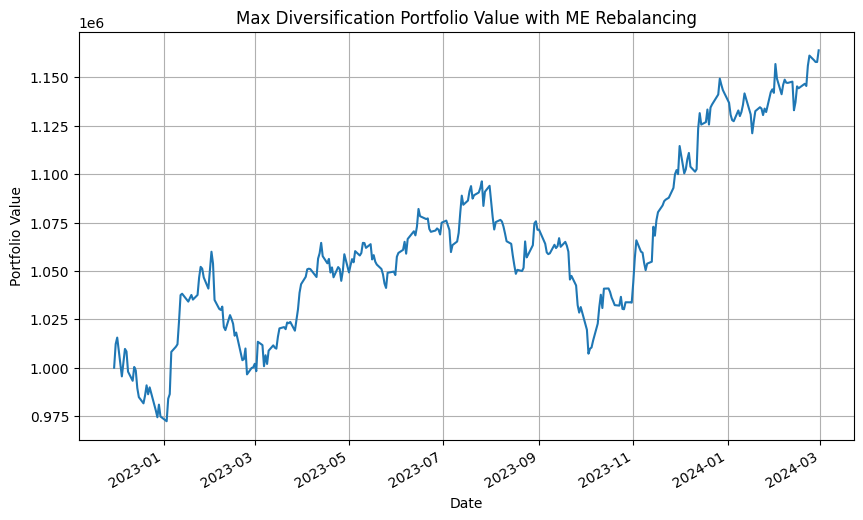

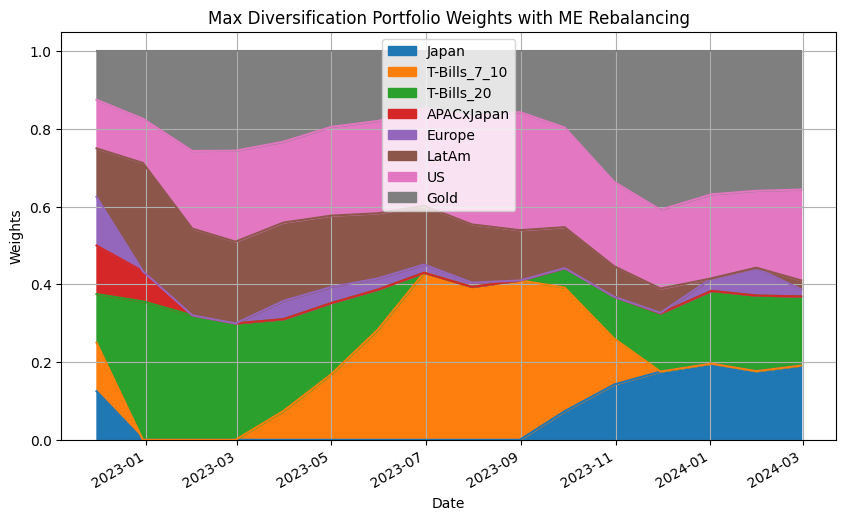

In [7]:
# Helper to calculate portfolio diversification
def calc_diversification_ratio(w, V):
    # Weighted volatility
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # Portfolio volatility
    port_vol = np.sqrt(np.dot(w.T, np.dot(V, w)))
    # Diversification ratio (maximize)
    diversification_ratio = w_vol / port_vol
    # Return negative for minimization problem
    return -diversification_ratio

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights sum to 1

# Function to calculate the cumulative return for each asset in the month
def calculate_cumulative_return(asset_returns):
    return (asset_returns + 1).prod() - 1

#Portfolio optimization function to maximize diversification
def max_diversification_optimizer(w0, V, bnd = [(0, 1) for _ in range(len(returns.columns))], long_only=True):
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only:  # add long only constraint
        cons = cons + ({'type': 'ineq', 'fun': lambda w: w},)

         # Add tolerance options for SLSQP
    options = {'maxiter': 1000, 'ftol': 1e-10, 'disp': True}  # Change these as needed

    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=(V,), method='SLSQP', constraints=cons, options=options)

    return res


def max_diversification_portfolio(returns, rebalance_frequency, initial_investment=1e6):
    rebal_dates = returns.resample(rebalance_frequency).last().index
    aligned_rebal_dates = returns.index.get_indexer(rebal_dates, method='nearest')
    rebal_dates = returns.index[aligned_rebal_dates]

    portfolio_value = pd.Series(index=returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_investment

    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=returns.columns, dtype=float)

    n_assets = returns.shape[1]
    w0 = np.ones(n_assets) / n_assets  # Equal initial weights
    bounds = [(0, 1) for _ in range(n_assets)]
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)

    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # Rebalancing loop
    for i in range(len(rebal_dates)):
        this_rebal_date = rebal_dates[i]

        # If not the first rebalancing date, compute new weights
        if i > 0:
            lookback_days = 180  # ~180 trading days (6 months)
            cov_start = this_rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:this_rebal_date]

            if cov_data.isna().any().any() or len(cov_data) < 2:
                print(f"Skipping rebalancing at {this_rebal_date} due to insufficient data.")
            else:
                # Optimize max diversification
                cov_matrix = cov_data.cov().values
                res = max_diversification_optimizer(w0, cov_matrix, bounds)
                if not res.success:
                    print(f"Optimization failed at {this_rebal_date}")
                else:
                    optimal_weights = res.x
                    assert np.isclose(np.sum(optimal_weights), 1), "Weights do not sum to 1."
                    assert all(0 <= w <= 1 for w in optimal_weights), "Weights are out of [0,1] bounds."
                    w0 = optimal_weights
                    portfolio_weights.loc[this_rebal_date] = w0

        # Portfolio value updates
        if i == 0:
            prev_rebal_date = portfolio_value.index[0]
        else:
            prev_rebal_date = rebal_dates[i - 1]

        daily_index_slice = portfolio_value.index[(portfolio_value.index >= prev_rebal_date) & (portfolio_value.index <= this_rebal_date)]

        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        daily_index_slice = portfolio_value.loc[final_rebal:].index
        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    return portfolio_value, portfolio_weights

#### Actual Function Call ####

rebalance_frequency = 'ME'  # Options: 'ME', 'QE', 'YE'
portfolio_value, portfolio_weights = max_diversification_portfolio(returns, rebalance_frequency)

# Plot portfolio value over time
portfolio_value.plot(figsize=(10, 6))
plt.title(f'Max Diversification Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Plot portfolio weights over time
portfolio_weights.plot(figsize=(10, 6), kind='area', stacked=True)
plt.title(f'Max Diversification Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [8]:
#### Max Div Portfolio Analytics ####

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_maxdiv = portfolio_value.resample('ME').ffill()
monthly_returns_maxdiv = monthly_portfolio_value_maxdiv.pct_change().dropna()

# 2) Full sample annualized monthly volatility
full_sample_monthly_vol = monthly_returns_maxdiv.std()
annualized_vol = full_sample_monthly_vol * np.sqrt(12)

# 3) Total return & Geo means
initial_val = portfolio_value.iloc[0]
final_val = portfolio_value.iloc[-1]
total_return_maxdiv = (final_val - initial_val) / initial_val

n_months = len(monthly_returns_maxdiv)
geo_avg_monthly_return_maxdiv = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_yearly_return_maxdiv = (1 + geo_avg_monthly_return_maxdiv) ** 12 - 1

# 5) Sharpe Ratio
arithmetic_monthly_return = monthly_returns_maxdiv.mean()  # Arithmetic mean of monthly returns
annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
sharpe_ratio_maxdiv = annualized_arithmetic_return / annualized_vol

# 6) Monthly 99% VaR
VaR_99_maxdiv = monthly_returns_maxdiv.quantile(1 - 0.99)

# 7) Print results
print("### Maximum Diversification Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol:.4f}")
print(f"Total return: {total_return_maxdiv * 100:.2f}%")

print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_maxdiv * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_maxdiv * 100:.2f}%")

print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_maxdiv:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_maxdiv:.4f}")


### Maximum Diversification Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.1257
Total return: 16.40%
Geometric avg monthly return (CAGR basis): 1.02%
Geometric avg yearly return (CAGR basis): 12.91%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 1.03
Monthly 99% Value at Risk (VaR): -0.0467
